# A simple example on how to extract the amplitude of a line, we lock on the harmonic and extract the max amplitude

In [1]:
import numpy as np
import pandas as pd
import os
import json
import getpass
import logging
import sys
import numpy as np
import datetime
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import glob
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patches as mpatches


/tmp/ipykernel_662/3181344496.py:23: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
df_fills = pd.read_parquet('fills.parquet', engine='pyarrow')

In [3]:
if df_fills['HX:FILLN'].iloc[0] == None:
    df_fills['HX:FILLN'].iloc[0] = df_fills['HX:FILLN'].dropna().iloc[0]
df_fills['HX:FILLN'] = df_fills['HX:FILLN'].ffill(axis=0)


/tmp/ipykernel_662/2477981038.py:49: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  idx.append(np.where(amp_strip[amp][:]==max_amp)[0])


<IPython.core.display.Javascript object>


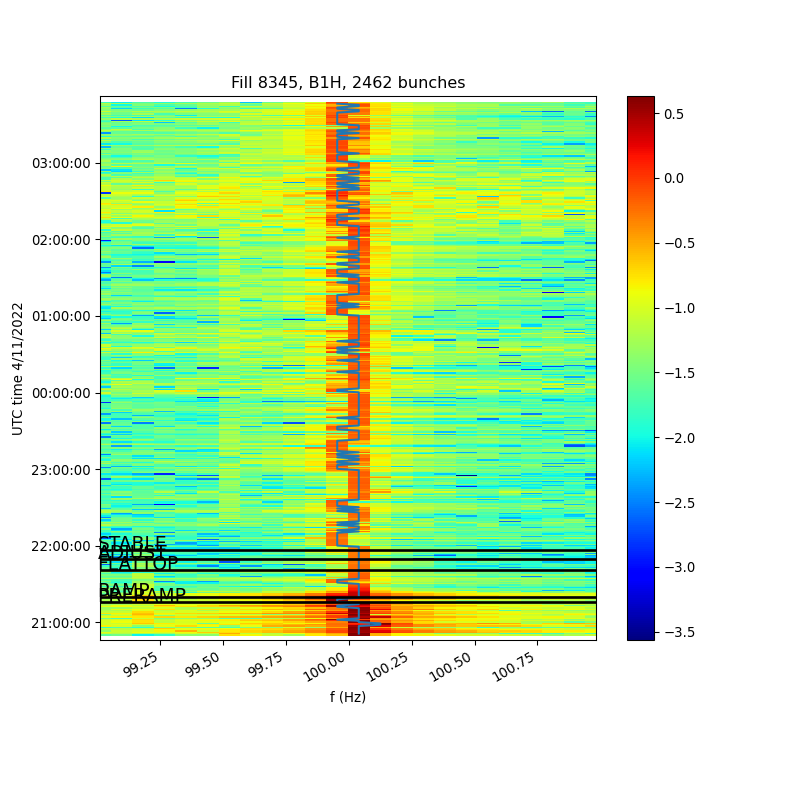

amp_strip (426, 24)


<IPython.core.display.Javascript object>


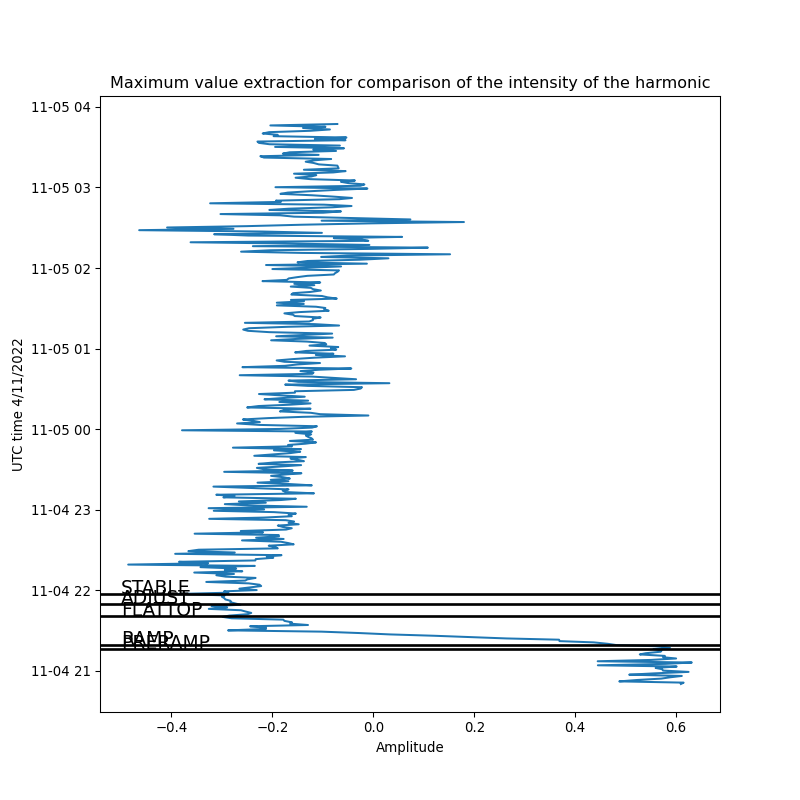

2022-11-04 21:16:10.627363525
2022-11-04 21:19:38.328738525
2022-11-04 21:40:57.375988525
2022-11-04 21:50:04.686613525
2022-11-04 21:56:57.935363525


In [7]:
%matplotlib notebook
df_fills = pd.read_parquet('fills.parquet', engine='pyarrow')

df = pd.read_parquet('/eos/user/a/aradosla/SWAN_projects/Analysis/ADTObsBox_analysis/results_nxcals/plots_8345/B1H/FFT_8345_B1H_2022-11-04 20:46:16.475330_2022-11-05 03:52:11.991358.parquet')
if df_fills['HX:FILLN'].iloc[0] == None:
  df_fills['HX:FILLN'].iloc[0] = df_fills['HX:FILLN'].dropna().iloc[0]
df_fills['HX:FILLN'] = df_fills['HX:FILLN'].ffill(axis=0)


for fill_nb in ['8345']:
    
    for beam_plane in ['B1H']: #, 'B2H', 'B1V', 'B2V']:
    
      if 1:
       
        df[df.columns[0]] = df[df.columns[0]].apply(lambda x: x['elements'])
        df.index = [pd.Timestamp(df.index[i]) for i in range(len(df))]
    
        df_fills = df_fills[df_fills['HX:FILLN'] == fill_nb]

        
        df_fills.index = [pd.Timestamp(df_fills.index[i]) for i in range(len(df_fills))]
  
        df_bunches = df_fills[f'LHC.BQM.B{beam_plane[1:2]}:NO_BUNCHES'].dropna().astype(int)
        bunches = df_bunches.max()
    

        for counter, ii in enumerate(range(99, 101,2)):#(range(0, 5000,200)):
           
            x_lims = mdates.date2num(df.index.values) 
            
            my_dpi=96
            frev=11245.5
            freqs = np.linspace(0, frev, len(df[df.columns[0]].iloc[0]))
            fourier_abs = np.array(df[df.columns[0]].to_list())

            ################################################
            myfilter = (freqs>ii) & (freqs<ii+2)
            line =100
            
            myfilter_strip = (freqs>line-1) & (freqs<line+1)                #filter for the frequency strip selection, around f = 100Hz
        
            amp_strip = np.array(np.log10(fourier_abs)[:, myfilter_strip])  #all amplitudes in the selected frequency domain
                                                                            #same expression as the heatmap color
            max_amp = []
            idx = []
            for amp in range(len(amp_strip)):                               #loop for calculating all the max amp values in the selected domain
                max_amp.append(amp_strip[amp][:].max())
                idx.append(np.where(amp_strip[amp][:]==max_amp)[0])
    
            idx=[]
            for i in range(len(amp_strip)):
                idx.append(np.where(amp_strip[i][:] == max_amp[i])[0].tolist())
    
            myfreq = freqs[myfilter_strip]
            f = ['']*len(idx)
            for i in range(len(idx)):
                f[i] = myfreq[idx[i]].tolist()


            fig, ax = plt.subplots(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
            
            print('amp_strip',amp_strip.shape)

            plt.pcolormesh(freqs[myfilter], df.index.values, np.array(np.log10(fourier_abs)[:, myfilter]), cmap='jet', shading='auto')
            plt.xlim(freqs[myfilter][0], freqs[myfilter][-1])
            plt.ylim(df.index.values[0], df.index.values[-1])
            plt.plot(f[5:-6], df.index.values[5:-6])
            plt.colorbar()
            ax.yaxis_date()
            date_format = mdates.DateFormatter('%H:%M:%S')
            ax.yaxis.set_major_formatter(date_format)
            plt.title(f'Fill {fill_nb}, {beam_plane}, {bunches} bunches')
            fig.autofmt_xdate()
            plt.xlabel('f (Hz)')
            plt.ylabel(f"UTC time {df.index[0].day}/{df.index[0].month}/{df.index[0].year}")
            
            for mode in ["PRERAMP", "RAMP", "FLATTOP", "ADJUST", "STABLE"]:#, "SQUEEZE", "STABLE"]:
                try:
                    tt=pd.Timestamp(df_fills[df_fills["HX:BMODE"] == mode].iloc[0].name)
                    plt.axhline(tt, c='k', lw=2)
                    plt.text(ii, tt, mode, c='k', fontsize=14)
                except:
                    print('prob', mode)
            plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
            
            plt.plot(max_amp, df.index.values)
            plt.xlabel('Amplitude')
            plt.ylabel(f"UTC time {df.index[0].day}/{df.index[0].month}/{df.index[0].year}")
            plt.title('Maximum value extraction for comparison of the intensity of the harmonic')
            for mode in ["PRERAMP", "RAMP", "FLATTOP", "ADJUST", "STABLE"]:#, "SQUEEZE", "STABLE"]:
                try:
                    tt=pd.Timestamp(df_fills[df_fills["HX:BMODE"] == mode].iloc[0].name)
                    print(tt)
                    plt.axhline(tt, c='k', lw=2)
                    plt.text(-0.5, tt, mode, c='k', fontsize=14)

                except:
                    print('prob', mode)
    

In [5]:
idx=[]
for i in range(len(amp_strip)):
    idx.append(np.where(amp_strip[i][:] == max_amp[i])[0].tolist())
myfreq = freqs[myfilter_strip]
f = ['']*len(idx)
for i in range(len(idx)):
    f[i] = myfreq[idx[i]].tolist()